Deep Belief Network (DBN)
Learning algorithm in DBN make use of generative model in order to pre-train the neural network weights into a reasonable configuration prior to backpropagation. 

Contents:
1. How to load the MNIST dataset and transform it using TensorFlow 2's Dataset API
2. How a Restricted Boltzmann Machine (RBM) -a simple neural network- is trained by minimizing an 'energy' equation that resembles formulas from physics to generate images.
3. How to stack several RBMs to make an DBN and apply forward and backward passes to pre-train this network to generate image data.
4. How to implement an end-to-end classifier by combining this pre-training with backpropagation "fine-tuning" using the Tensorflow2 API.

In [1]:
from __future__ import absolute_import, division, print_function
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# __future__ allows you to higher version of python functions

2023-04-17 23:15:31.867130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 23:15:34.150652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mnist_builder = tfds.builder("mnist") # downloads from google cloud storage
mnist_builder.download_and_prepare() 

In [6]:
type(mnist_builder)

tensorflow_datasets.image_classification.mnist.MNIST

In [3]:
info = mnist_builder.info # already splited by 10000 test and 60000 train data
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/baebae/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

2023-04-17 23:15:49.766179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 23:15:53.657083: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


2023-04-17 23:15:54.240784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-04-17 23:15:54.241409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-04-17 23:15:54.790753: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

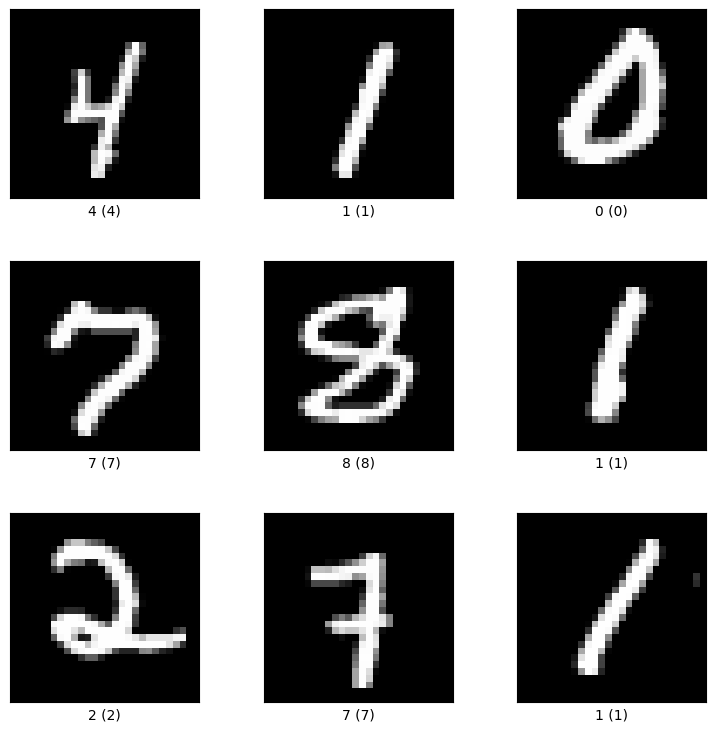

In [4]:
mnist_train = mnist_builder.as_dataset(split="train")
mnist_test = mnist_builder.as_dataset(split="test")
fig = tfds.show_examples(info, mnist_train) # visualize plot

Label: 4
Label: 1
Label: 0
Label: 7


2023-04-17 23:31:19.371750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-04-17 23:31:19.372403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-04-17 23:31:19.431132: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

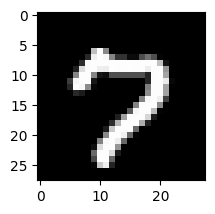

In [16]:
from functools import partial

def flatten_image(x, label=False):
    if label:
        return (tf.divide(
            tf.dtypes.cast(
            tf.reshape(
            x["image"], (1,28*28)), # reshape : flatten 'image'
              tf.float32), # cast dtyps of tensors to float32
                256.0), # divide each tensor with 256 for normalization
                x["label"]) # returns a tuple set of (image, label)
    else:
        return (tf.divide(tf.dtypes.cast(tf.reshape(x["image"], (1,28*28)), tf.float32), 256.0))

flatten_image = partial(flatten_image, label=True)

for image, label in mnist_train.map(flatten_image).take(4):
    i = 1
    plt.subplot(2,2,i)
    plt.imshow(image.numpy().reshape(28,28).astype(np.float32),
               cmap=plt.get_cmap("gray"))
    
    print("Label: %d" % label.numpy())
    i += 1

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


2023-04-17 23:32:26.552643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-04-17 23:32:26.553151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-04-17 23:32:26.597564: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

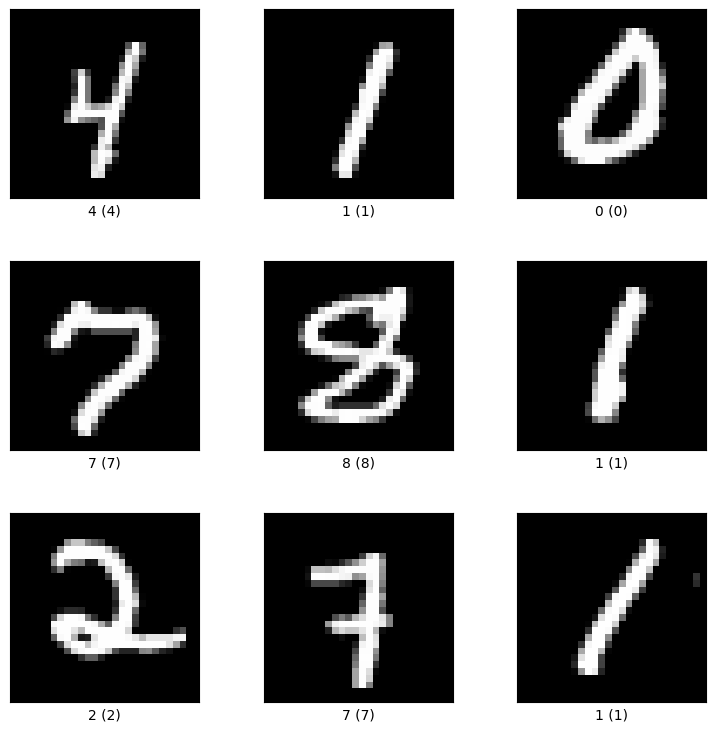

In [17]:
mnist_train.map(flatten_image).take(1)
fig = tfds.show_examples(info, mnist_train)

Label: 4


2023-04-17 23:35:02.007419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-04-17 23:35:02.007831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-04-17 23:35:02.045628: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

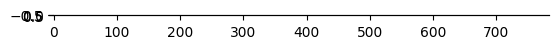

In [18]:
for mnist_example in mnist_train.take(1):
    image, label = mnist_example["image"], mnist_example["label"]

    plt.imshow(image.numpy().ravel().reshape(1,-1).astype(np.float32), cmap=plt.get_cmap("gray"))
    print("Label: %d" % label.numpy())

In [20]:
mnist_train.map(flatten_image).element_spec
# Each image and label

(TensorSpec(shape=(1, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))